In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 35.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Draw
from IPython.display import display
from sklearn import svm
from sklearn.model_selection import train_test_split
from rdkit.Chem import AllChem
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# Read the dataset
df = pd.read_csv('/kaggle/input/2024-1-cuk-gm-project/BBBP.csv')

num                                 26
name                                12
p_np                                 0
smiles    CCNC(=NC#N)NCCSCc1c(cccn1)Br
Name: 25, dtype: object


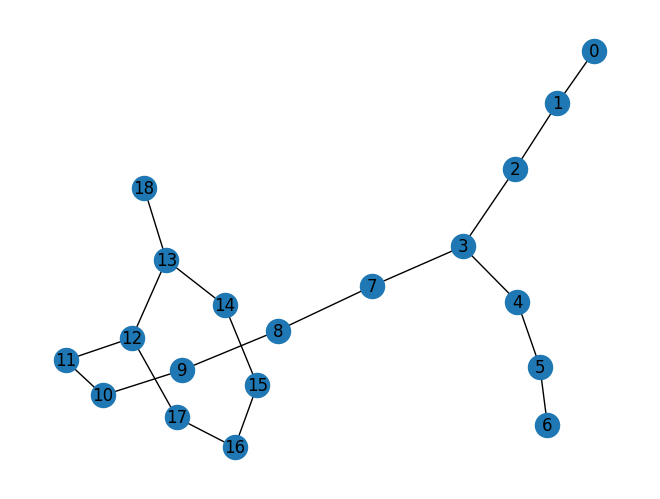

In [4]:
# Display the first row of the dataset
print(df.iloc[25])

graphs = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    graphs.append(G)

#Visualize the first graph
nx.draw(graphs[25], with_labels=True)

In [5]:
print(df.iloc[0:25])

    num                  name  p_np  \
0     1            Propanolol     1   
1     2  Terbutylchlorambucil     1   
2     3                 40730     1   
3     4                    24     1   
4     5           cloxacillin     1   
5     6          cefoperazone     1   
6     7      rolitetracycline     1   
7     8           ondansetron     1   
8     9             diltiazem     1   
9    10             Amiloride     1   
10   11            M2L-663581     0   
11   12             alovudine     1   
12   13                    18     1   
13   14                 24959     1   
14   15             methadone     1   
15   16            alfentanil     1   
16   17              BRL53080     1   
17   18           hyoscyamine     1   
18   19             glyburide     1   
19   20           lamotrigine     1   
20   21       2-Methylpentane     1   
21   22         Dexamfetamine     1   
22   23             SKF-93619     0   
23   24               nadolol     1   
24   25            sufent

Propanolol


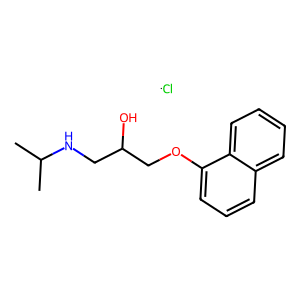

Terbutylchlorambucil


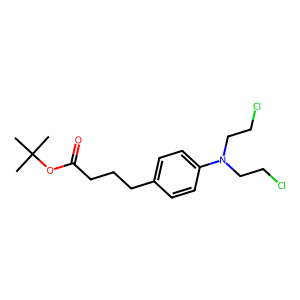

40730


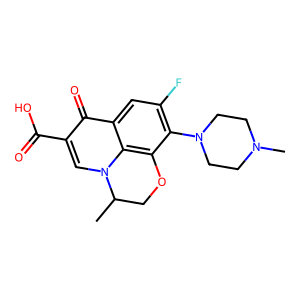

24


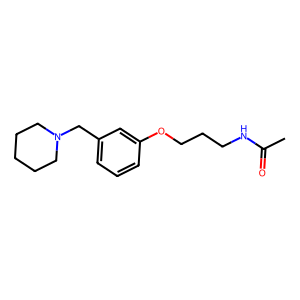

cloxacillin


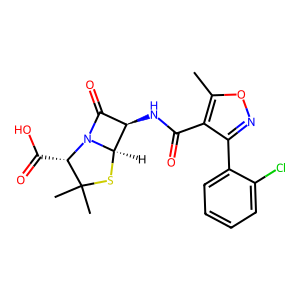

In [6]:
# Load the dataset
data = pd.read_csv('/kaggle/input/2024-1-cuk-gm-project/BBBP.csv')

# Visualize each molecule
for idx, row in data.head(5).iterrows():
    smiles = row['smiles']
    name = row['name']
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        img = Draw.MolToImage(mol, size=(300, 300))

        print(name)
        display(img)

In [7]:
# Load the dataset
data = pd.read_csv("/kaggle/input/2024-1-cuk-gm-project/BBBP_train.csv")
test_data = pd.read_csv("/kaggle/input/2024-1-cuk-gm-project/BBBP_test.csv")

# Drop rows with NaN values in SMILES column
data.dropna(subset=['smiles'], inplace=True)
test_data.dropna(subset=['smiles'], inplace=True)

In [8]:
# SMILES sanitization function
def sanitize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            Chem.SanitizeMol(mol)
            return mol
    except Exception as e:
        print(f"Sanitization error with SMILES {smiles}: {e}")
    return None

# Data preprocessing and feature extraction
def smiles_to_graph(smiles):
    mol = sanitize_smiles(smiles)
    if mol is not None:
        return nx.Graph(Chem.rdmolops.GetAdjacencyMatrix(mol))
    return None

In [9]:
# Feature extraction functions
def clustering_coefficient(graph):
    if len(graph) > 1:
        return nx.average_clustering(graph)
    return np.nan  # Return NaN if graph has less than 2 nodes

def jaccard_coefficient(graph):
    if len(graph) > 1:
        return np.mean([c for _, _, c in nx.jaccard_coefficient(graph)])
    return np.nan  # Return NaN if graph has less than 2 nodes

def modularity(graph):
    if len(graph) > 1:
        communities = nx.community.greedy_modularity_communities(graph)
        return nx.algorithms.community.quality.modularity(graph, communities)
    return np.nan  # Return NaN if graph has less than 2 nodes


In [10]:
# Generate graphs and extract features for training data
train_features = []
valid_smiles = []
for smile in data['smiles']:
    graph = smiles_to_graph(smile)
    if graph is not None:
        # Extract features
        feature = [
            clustering_coefficient(graph),
            jaccard_coefficient(graph),
            modularity(graph)
        ]
        train_features.append(feature)
        valid_smiles.append(smile)

# Get labels corresponding to valid SMILES
valid_labels = data.loc[data['smiles'].isin(valid_smiles), 'p_np'].values

# Remove NaN values from features and labels
train_features_df = pd.DataFrame(train_features, columns=['clustering_coefficient', 'jaccard_coefficient', 'modularity'])
train_features_df['label'] = valid_labels
train_features_df.dropna(inplace=True)

# Split dataset into training and testing sets
X_train = train_features_df[['clustering_coefficient', 'jaccard_coefficient', 'modularity']].values
y_train = train_features_df['label'].values
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

[14:58:45] WARNING: not removing hydrogen atom without neighbors
[14:58:45] WARNING: not removing hydrogen atom without neighbors
[14:58:45] WARNING: not removing hydrogen atom without neighbors
[14:58:45] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:58:46] WARNING: not removing hydrogen atom without neighbors
[14:58:46] WARNING: not removing hydrogen atom without neighbors
[14:58:46] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:58:47] WARNING: not removing hydrogen atom without neighbors
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[14:58:48] WARNING: not removing hydrogen atom without neighbors
[14:58:48] WARNING: not removing hydrogen atom without neighbors
[14:58:48

In [11]:
# Train an SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = clf.predict(X_val)
print("Validation Classification report:\n", classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# Generate graphs and extract features for test data
test_features = []
test_smiles = []
for smile in test_data['smiles']:
    graph = smiles_to_graph(smile)
    if graph is not None:
        # Extract features
        feature = [
            clustering_coefficient(graph),
            jaccard_coefficient(graph),
            modularity(graph)
        ]
        test_features.append(feature)
        test_smiles.append(smile)

# Get labels corresponding to valid SMILES
test_labels = test_data.loc[test_data['smiles'].isin(test_smiles), 'p_np'].values

# Remove NaN values from features and labels
test_features_df = pd.DataFrame(test_features, columns=['clustering_coefficient', 'jaccard_coefficient', 'modularity'])
test_features_df['label'] = test_labels
test_features_df.dropna(inplace=True)

# Predict and evaluate on test set
X_test = test_features_df[['clustering_coefficient', 'jaccard_coefficient', 'modularity']].values
y_test = test_features_df['label'].values
y_test_pred = clf.predict(X_test)
print("Test Classification report:\n", classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.78      1.00      0.87       285

    accuracy                           0.78       367
   macro avg       0.39      0.50      0.44       367
weighted avg       0.60      0.78      0.68       367

Validation Accuracy: 0.776566757493188


[14:59:01] WARNING: not removing hydrogen atom without neighbors
[14:59:01] WARNING: not removing hydrogen atom without neighbors
[14:59:01] WARNING: not removing hydrogen atom without neighbors
[14:59:01] WARNING: not removing hydrogen atom without neighbors


Test Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.77      1.00      0.87       157

    accuracy                           0.77       205
   macro avg       0.38      0.50      0.43       205
weighted avg       0.59      0.77      0.66       205

Test Accuracy: 0.7658536585365854


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


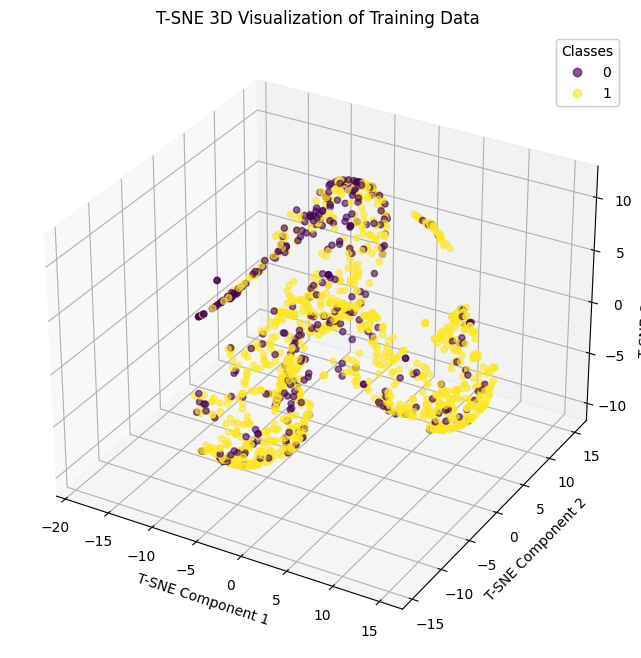

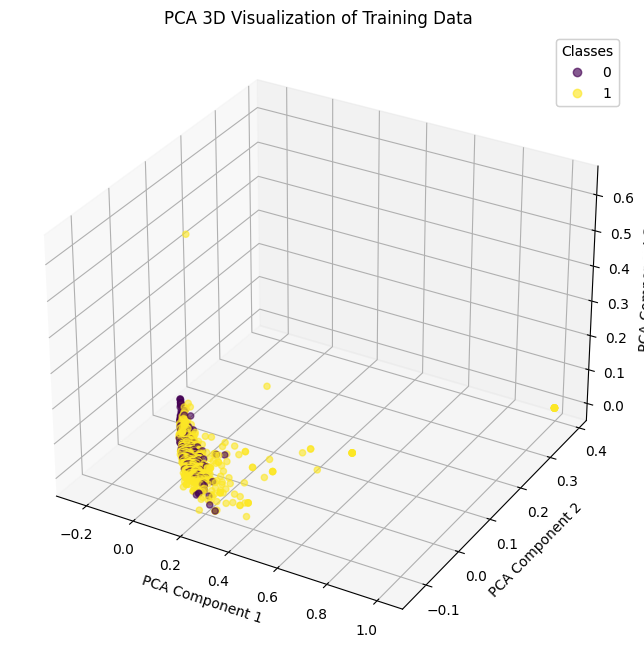

In [12]:
# T-SNE 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=y_train, cmap='viridis', alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('T-SNE 3D Visualization of Training Data')
ax.set_xlabel('T-SNE Component 1')
ax.set_ylabel('T-SNE Component 2')
ax.set_zlabel('T-SNE Component 3')
plt.show()

# PCA 3D visualization
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('PCA 3D Visualization of Training Data')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()